### Technical Report 

[Problem & Goals](#a) | [Data Source](#b) | [Data Munging](#c) | [Exploratory Data Analysis](#d) | [Image Preprocessing](#e) | [Model](#f) | [Results](#g) | [Summary](#h)

In [1]:
# general imports
import os, glob, fnmatch, pickle, itertools
import pandas as pd
import numpy as np

# plotting functions
from functions import *

# image processing imports
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image as image_utils

# modeling imports (using Tensorflow)
from keras.models import model_from_json


# classification metrics imports
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report, confusion_matrix, \
accuracy_score, precision_score, recall_score

# plotting imports
import seaborn as sns
import matplotlib
from matplotlib import colors
from matplotlib import pyplot as plt
from matplotlib import cm as cm
%matplotlib inline

Using TensorFlow backend.


---

## <a name="a">Problem & Goals</a>

### Introducing Pizza Dectector™
Ever wonder if there is pizza in your immediate surroundings? Consider the scenario where you're at a party — you've had one too many libations and things start to get kinda fuzzy... is that pizza or seven layer dip in front of you? It can be hard to tell, right?! (But probably only marginally depending on any pre-existing vision problems and/or the seven layer dip recipe). Or let's say you find yourself in a TGI Fridays (completely ironically of course) and order a 'BBQ Chicken Flatbread Pizza' and you ask yourself "but is this _**really**_ pizza?" all while pondering whether to add #pizza to your Valencia filtered (who even uses that on food photos?!) pic of this now suddenly debatable "pizza". Maybe you are currently on an all pizza diet and you're just tired of constantly mentally assessing whether food items are pizza or not. Or maybe you just really love pizza and think it would be silly but fun to detect pizza from, well, photos of pizza. All ridiculous problems solved by the Pizza Detector™ (works on lactose gluten free pizza too).

### Ok but seriously...
Jokes aside, the actual goal of this project is to first develop & train a model that recognizes a specific food category (in this case pizza, because pizza has a more distinctive appearance than a food like tacos) from a single image of that particular food. A longer term goal would be to expand the model to be a multi-label classifier that recognizes many other food categories and then ultimately predicts calories and other nutritional info from a photo. The use cases for this are pretty self-explanatory — tracking food intake for weight loss or to manage medical conditions (ie diabets, food allergies, etc) can be fairly labor intensive (and frankly annoying) as it usually requires manually entering nutritional info into a fitness/food tracking app. Because of this, most people don't stick with tracking their food intake for very long and this potentially can lead to weight gain and other health problems. 



---

## <a name="b">Data Source</a>

The data set is comprised of 2,000 food photos that are labeled "not pizza" plus 2,000 photos labeled "pizza" that come from randomly sampling [The Food-101 Data Set](https://www.vision.ee.ethz.ch/datasets_extra/food-101/) (and supplementing with an additional 1,000 photos of pizza from [ImageNet](http://image-net.org/synset?wnid=n07873807)). The Food-101 Data Set dataset includes a 101 food categories, with 1,000 images per category taken from [Foodspotting.com](http://www.foodspotting.com/). The data set still contains some noise — mostly in the form of intense colors and some wrong labels. 

See the data setup [here](code/data_setup.ipynb).

In [2]:
# Dictionary of food categories and number of images
path = '/Users/VanessaG/Desktop/DSI-SF-2-vnessified/capstone/data_sources/food-101/images'
food_categories = {}
folders = os.listdir(path)
for folder in folders[2:]:
    food_categories[folder] = len(os.listdir(os.path.join(path,folder)))
print food_categories

{'churros': 1000, 'hot_and_sour_soup': 1000, 'samosa': 1000, 'sashimi': 1000, 'pork_chop': 1000, 'spring_rolls': 1000, 'panna_cotta': 1000, 'beef_tartare': 1000, 'greek_salad': 1000, 'foie_gras': 1000, 'tacos': 1000, 'pad_thai': 1000, 'poutine': 1000, 'ramen': 1000, 'pulled_pork_sandwich': 1000, 'bibimbap': 1000, 'beignets': 1000, 'apple_pie': 1000, 'crab_cakes': 1000, 'risotto': 1000, 'paella': 1000, 'steak': 1000, 'baby_back_ribs': 1000, 'miso_soup': 1000, 'frozen_yogurt': 1000, 'club_sandwich': 1000, 'carrot_cake': 1000, 'falafel': 1000, 'bread_pudding': 1000, 'chicken_wings': 1000, 'gnocchi': 1000, 'caprese_salad': 1000, 'creme_brulee': 1000, 'escargots': 1000, 'chocolate_cake': 1000, 'tiramisu': 1000, 'spaghetti_bolognese': 1000, 'mussels': 1000, 'scallops': 1000, 'baklava': 1001, 'edamame': 1000, 'macaroni_and_cheese': 1000, 'pancakes': 1000, 'garlic_bread': 1000, 'beet_salad': 1000, 'onion_rings': 1000, 'red_velvet_cake': 1000, 'grilled_salmon': 1000, 'chicken_curry': 1000, 'dev

---

## <a name="c">Data Munging</a>
Because the data is all image based in the form of pixels, the concept of "cleaning" isn't really applicable. It does make sense to employ standardizaiton techniques to adjust for differences in lighting and maybe artifacts caused by different camera types, etc used in the photography of the food items. I used the Keras `ImageDataGenerator` class to do this in image preprocessing following EDA.   

However, I do some data munging using OpenCV methods to explore the relationshop between RGB & HSV color spaces on pizza versus non pizza images. First, I read in each image with `cv2.imread()`, normalize with `cv2.normalize()` — this divides each pixel's value by the sum of the pixels value over all channels which removes distortions caused by lights and shadows in the image. 

Then using `cv2.mean()` I calculate the mean RGB and HSV values for each image returning tuples from `cv2.cvtColor()` using attributes `cv2.COLOR_BGR2RGB` and `cv2.COLOR_BGR2HSV` respectively. I created a dataframe from the color values and add height, width and total pixels just for good measure (since images are represented by numpy arrays, using `.shape` gives pixel height, width and 3 color channels). 

See the data munging [here](code/data_munging.ipynb).

In [3]:
img_info = pd.read_csv('data/image_info.csv', index_col=0)
img_info.head()

,label,red,green,blue,hue,sat,val,img_height,img_width,total_px,short_path,full_path
0,0,0.232010,0.121889,0.040963,36.224313,0.808038,0.232448,512,384,196608,train/not_pizza/10060.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...
1,0,0.637750,0.452795,0.490195,205.991908,0.468141,0.679158,512,512,262144,train/not_pizza/1008028.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...
2,0,0.398433,0.340697,0.371352,175.903364,0.374069,0.461239,512,512,262144,train/not_pizza/1008185.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...
3,0,0.584648,0.307440,0.103829,64.419616,0.809770,0.584693,512,512,262144,train/not_pizza/1012128.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...
4,0,0.512543,0.472196,0.413072,104.964425,0.303246,0.529292,512,512,262144,train/not_pizza/1013559.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...


---

## <a name="d">Exploratory Data Analysis</a>
Plots and images below using seaborn's `distplot()` to show a histogram of color info in photos, a correlation matrix to show the relationship between features and images from the data reflecting the strongest relationships from the correlation matrix. 

In [4]:
#total number of pixels!
img_info['total_px'].sum()

875389264

### RGB Histograms

RGB images are made of up 3 color channels — red, green, and blue and each pixel in the image will consist of three in some numeric value on a scale of 0-255 to make up millions of different color combinations. Here I looked at the normalized (0 to 1 scale) distributions of the mean (to control for image dimensions) red, green and blue pixels in pizza and non pizza images to evaluate if there is any difference between pixel color distributions in pizza versus non pizza images. There clearly is no real discernible difference.

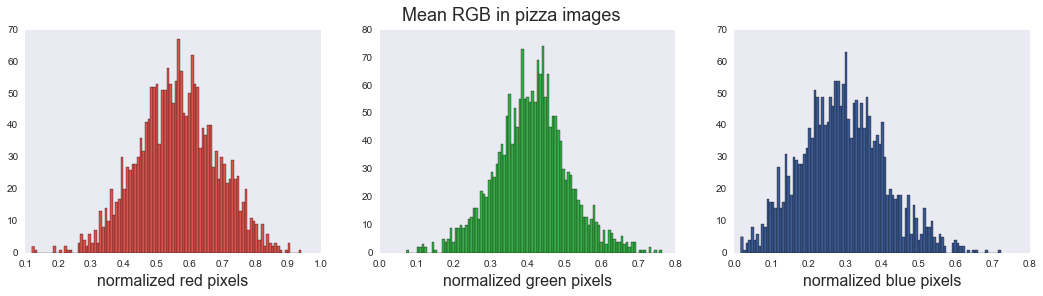

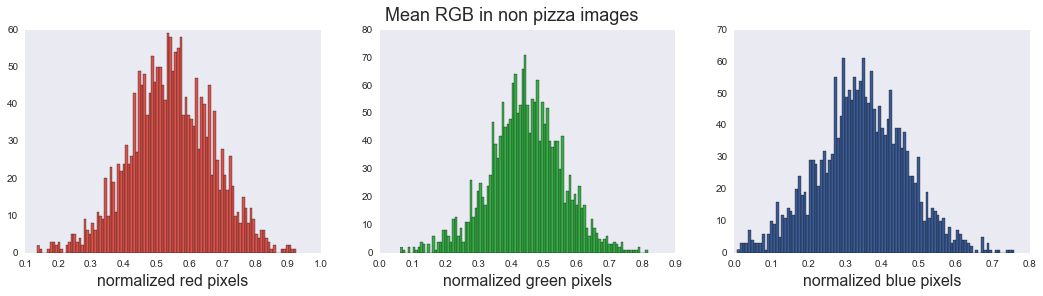

In [5]:
color_space_plots(img_info.red[img_info.label == 1], sns.xkcd_rgb["pale red"], "normalized red pixels", 
    img_info.green[img_info.label == 1], sns.xkcd_rgb["medium green"], "normalized green pixels", 
    img_info.blue[img_info.label == 1], sns.xkcd_rgb["denim blue"], "normalized blue pixels", 
    "Mean RGB in pizza images")

color_space_plots(img_info.red[img_info.label == 0], sns.xkcd_rgb["pale red"], "normalized red pixels", 
    img_info.green[img_info.label == 0], sns.xkcd_rgb["medium green"], "normalized green pixels", 
    img_info.blue[img_info.label == 0], sns.xkcd_rgb["denim blue"], "normalized blue pixels", 
    "Mean RGB in non pizza images")

### HSV Histograms
HSV stands for hue, saturation, and value — also called HSB (B for brightness). Because HSV separates color (hue) information from intensity (saturation) and lighting (value) it's often used in vision and image processing because the information is less noisy than RGB information. Along the same lines as the RGB histograms above, I compared the normalized distributions of the mean HSV in pizza versus non pizza images to see if there is any differences — and like with RGB values, there is really no difference.

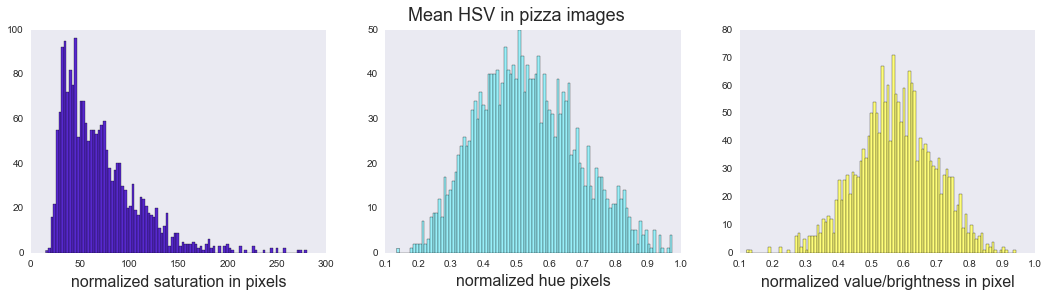

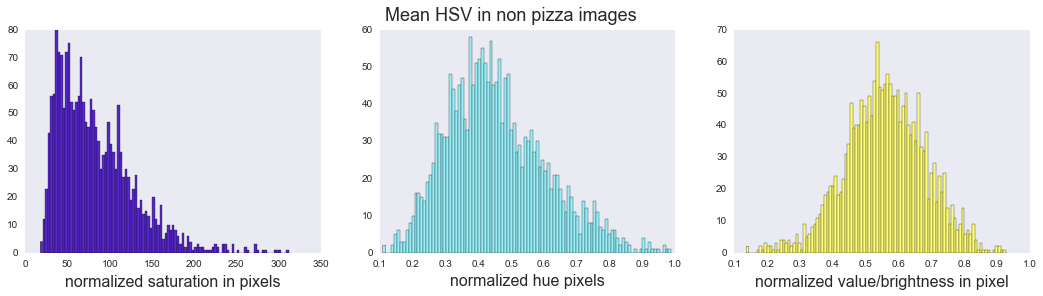

In [6]:
color_space_plots(img_info.hue[img_info.label == 1], sns.xkcd_rgb["blue purple"], "normalized saturation in pixels", 
    img_info.sat[img_info.label == 1], sns.xkcd_rgb["robin's egg blue"], "normalized hue pixels", 
    img_info.val[img_info.label == 1], sns.xkcd_rgb["light yellow"], "normalized value/brightness in pixel", 
    "Mean HSV in pizza images")

color_space_plots(img_info.hue[img_info.label == 0], sns.xkcd_rgb["blue purple"], "normalized saturation in pixels", 
    img_info.sat[img_info.label == 0], sns.xkcd_rgb["robin's egg blue"], "normalized hue pixels", 
    img_info.val[img_info.label == 0], sns.xkcd_rgb["light yellow"], "normalized value/brightness in pixel", 
    "Mean HSV in non pizza images")

### Pearson Correlation

Here I'm looking for any linear relationship between label (pizza vs not pizza) and the different potential "features" I've identified so far — the amount of red, green, blue, hue, saturation and value in an image. There's slight positive relationship between images of pizza and saturation and slight negative relationship between the amount of blue and images of pizza. Image height is negatively correlated with pizza and while that's probably mostly nonsense (and depends on more on the data source) it again also kind of intuitiviely makes sense, in that images of pizza are generally square or have a wider aspect ratio.

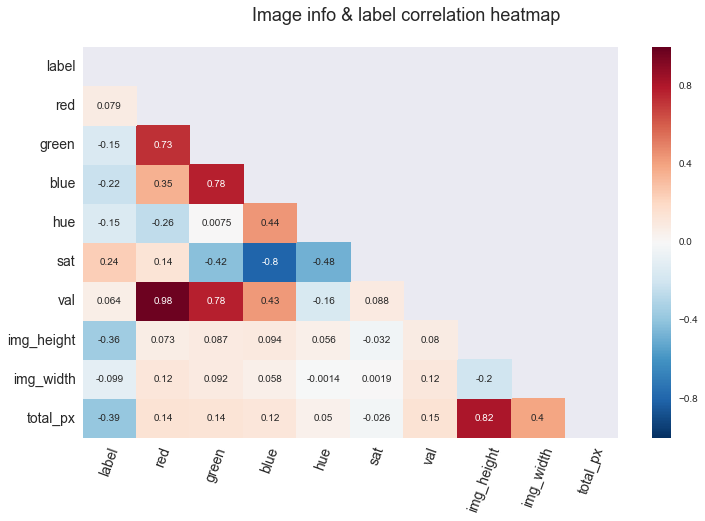

In [7]:
corr(img_info, 'Image info & label correlation heatmap')

Plotting the images with the highest saturation and the most blue, you can see while these correlations kind of intuitiviely makes sense on some level, using these features as the basis for an image classifier would also probably result in a high number of missclassified images. Overall the EDA, albeit pretty surface level, conveys that image classification based on pixels, essentially imitating the highly granular functionality of human eye and brain, can't really be based on something as simple as color features alone and supports the use of a more complex modeling technique like a convolutional neural network.

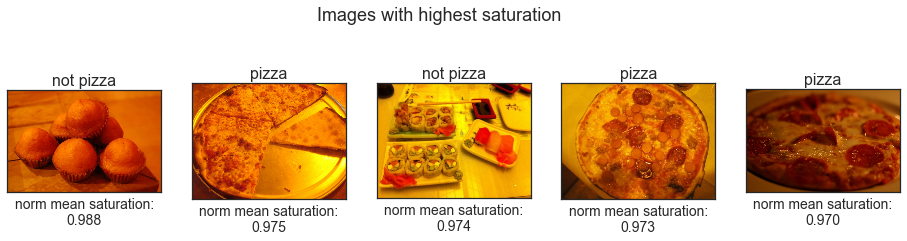

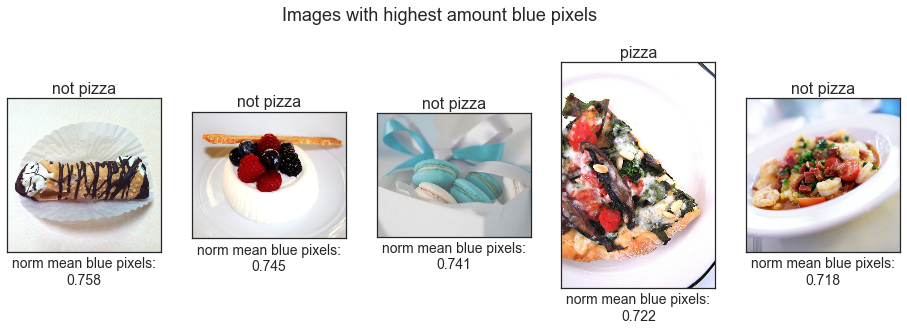

In [8]:
sat_df = img_info.sort_values('sat', ascending=False)
img_plots(4, sat_df['full_path'], 'Images with highest saturation', sat_df.label, "norm mean saturation:", sat_df.sat)

blue_df = img_info.sort_values('blue', ascending=False)
img_plots(5, blue_df['full_path'], 'Images with highest amount blue pixels', blue_df.label, "norm mean blue pixels:", blue_df.blue)

---
## <a name="e">Image Preprocessing</a>

The goal with this preprocessing is to augment the images via random transformations so the model generalizes better. This lets you to train your model to better handle natural variation in orientation, rotation, perspective, etc in the image data by randomly flipping orientation, rotatation, and sheer range in the images during training. For example, if you only showed your model images of pizza with the crust orientated left, it may not be able to properly classify images of pizza with the crust orientated right.

Keras has an `ImageDataGenerator` class that lets you perform these transformations "just-in-time" (rather than all at once) while you fit your model by iterating in an infinite loop, getting batches of images by calling `.flow()` or `.flow_from_directory()`. It can also standardize pixel values across all the image data by using feature standardization (which is like standardization methods you'd use on tabular data) — by default standardization is set to True.

Below is an example of `ImageDataGenerator` class and what the tranformation it yields.

See the full `ImageDataGenerator` example [here](code/image_preprocessing_example.ipynb).

In [9]:
# example of transformations
datagen = ImageDataGenerator(
    
    #integer value range in degrees(0-180) to randomly rotate images
    rotation_range=40,

    #width_shift & height_shift are ranges within which to randomly translate/shift
    width_shift_range=0.2,
    height_shift_range=0.2,

    #randomly applying shearing transformations
    shear_range=0.2,

    #randomly zooming inside pictures
    zoom_range=0.2,

    #randomly flips half of the images horizontally
    #relevant when no assumptions of horizontal assymetry - ie real-world pictures
    horizontal_flip=True,

    #strategy for filling newly created pixels
    fill_mode='nearest')

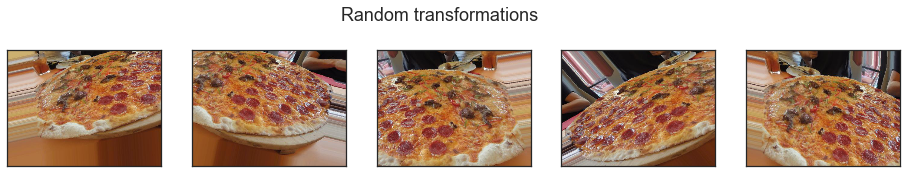

In [10]:
pizza_transformed = [f for f in glob.glob('./images/example_transformations/*') if f.endswith('.jpg')]
img_plots(3, pizza_transformed, 'Random transformations')

---
## <a name="f">Model</a>
Classification based on detecting an object (this case pizza!) in an image is incredibly complex because the same object can vary in position, angles, lighting, etc. Part of the image can be hidden as well as there is background clutter to deal with. With all this information being represented in the image's pixels, images are higly dimensional — to use a logistic regression on image classification it would mean that each pixel value is a feature. You could form a sort of template from a weighted sum of the pixel features but it wouldn't generalize well at all to images of the same object but with the object in a different position, etc.

What you really need to classify an image based on an object is a way to understand and retain the info on the spatial relationship between pixels in a more flexible way. Learning these relationships by using small sections of pixels in the image data, that move across the whole image, allows features to be learned in such a way that if objects are in a different position, etc they can still be detected/classified. This is why convolution neural networks are well suited for object recognition tasks because like I mentioned earlier, they are in effect imitating the functionality of human brain and eye. 

### Load previously trained model

For modeling I used Keras running on top Tensorflow on an AWS EC2 instance. I used four convolutional layers and max-pooling layers plus two fully connected layers, for a total of 18 layers. Generally for more complex tasks, you may want more convolutional layers to extract higher and higher level features. 

Once defined, I compiled the model where I specify the loss function and the optimizer to be used ('binary_crossentropy' and 'rmsprop'). After compiled, the model is fit to data on image generator functions for train and validation data.

See the full model [here](code/model.ipynb).

In [11]:
# path to images for .flow_from_directory() to pass in images
validation_data_dir = '/Users/VanessaG/Desktop/pizza_class_data/validation'

# resize images to these dimensions
img_width, img_height = 150, 150

# augmented image generator for validation set - really only rescaling here
test = ImageDataGenerator(
    rescale=1./255)

# generates validation images
validation_generator = test.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        shuffle=False,
        class_mode='binary')

Found 800 images belonging to 2 classes.


In [12]:
# load json and create model
json_file = open('./code/model_and_weights/pizza_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [13]:
# load weights into new model
loaded_model.load_weights("./code/model_and_weights/weights.best.hdf5")

In [14]:
# compile loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [15]:
# needs to be reset each time the generator is called
validation_generator.reset()

In [16]:
loaded_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 148, 148, 32)  896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 148, 148, 32)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 74, 74, 32)    0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 72, 72, 32)    9248        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

---

## <a name="g">Results</a>
Below I examine the model's overall accuracy, training/validation accuracy/loss over epochs as well as employ a confusion matrix, classification report, and the ROC curve to further evaluate the model's ability to detect pizza in an image.

### Accuracy & loss across epochs
Through the process of back-propagation, during each epoch (100 total) the parameters (the weights generated during the convolutional layers) of the model are adjusted to minimize the loss function. The results are the weights that have the ability to best generalize the model to new data it's not yet seen and this is reflected in the validation accuracy.

If the training accuracy keeps improving while validation accuracy gets worse, there is likely overfitting. The training loss also drops due to over-fitting. Fortunately, the model's validation accuracy is always better than the test accuracy, even from the 1st epoch. This itself is a bit curious, as generally accuracy on validation data accuracy is worse. Some possible explanations for this are the fact that the training loss is the average of all the losses for each batch of training data. Whereas validation loss for each epoch is the loss calculated at the very end of the epoch. Regulaziation such as Dropout are also not applied to validation data. 

In [33]:
# loss and accuracy
loaded_model.evaluate_generator(validation_generator, 800, max_q_size=10, nb_worker=1)

[0.31805022100838803, 0.88249999999999995]

In [18]:
# load model history object
fileObject = open('./code/model_history','r')  
history = pickle.load(fileObject)  

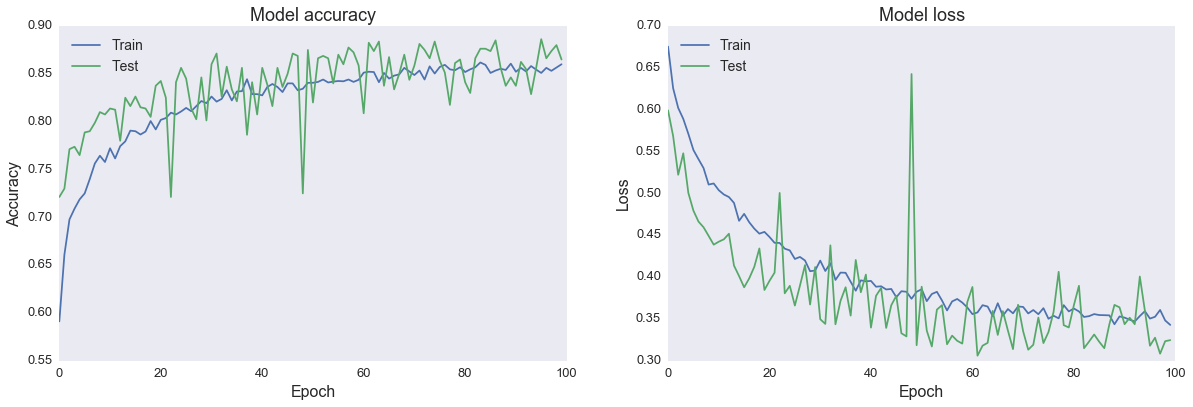

In [19]:
# A plot of accuracy and loss on the training and validation datasets over training epochs.
epoch_plot(history['acc'], history['val_acc'], history['loss'], history['val_loss'])

### Individual predictions
How good is this thing...

In [20]:
predictions = []
predicted_labels = []
for i, (img, y) in enumerate(validation_generator):
    if i >= 800:
        break
    pp = loaded_model.predict(img)
    label = int(pp[0] >= 0.5)
    predictions.append(pp[0][0])
    predicted_labels.append(label)  

In [21]:
pizzas = glob.glob(validation_data_dir+'/pizza/*.jpg')
not_pizzas = glob.glob(validation_data_dir+'/not_pizza/*.jpg')

In [22]:
image_file_predictions = {}

for i, filename in enumerate(not_pizzas+pizzas):
    image_file_predictions[filename] = {
        'predicted_prob_pizza':predictions[i],
        'predicted_label':predicted_labels[i]
    }

In [23]:
predictions_df = pd.DataFrame(image_file_predictions)
predictions_df = predictions_df.T.reset_index()

In [24]:
predictions_df.columns = ['filepath','predicted_label','predicted_prob_pizza']
predictions_df['actual_label'] = predictions_df.filepath.map(lambda x: 0 if '/not_pizza/' in x else 1)

In [25]:
predictions_df.head()

,filepath,predicted_label,predicted_prob_pizza,actual_label
0,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.643637,0
1,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.329799,0
2,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.150163,0
3,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.055289,0
4,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.425852,0


### Confusion Matrix

- True Positive = Predicted pizza and image is of pizza
- False Negative = Predicted not pizza and image is not pizza
- False Positive = Predicted pizza but image is not pizza
- True Negative = Predicted not pizza but actually pizza

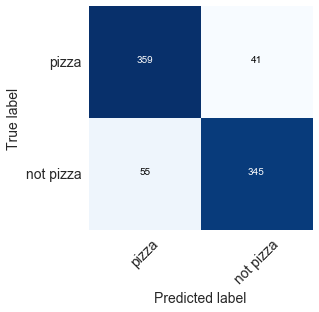

In [26]:
classes = ['pizza', 'not pizza']
conf_matrix_plot(predictions_df.actual_label, predictions_df.predicted_label, classes)

### Classification Report

In [27]:
print(classification_report(predictions_df['actual_label'], predictions_df['predicted_label']))

             precision    recall  f1-score   support

          0       0.87      0.90      0.88       400
          1       0.89      0.86      0.88       400

avg / total       0.88      0.88      0.88       800



### ROC Curve

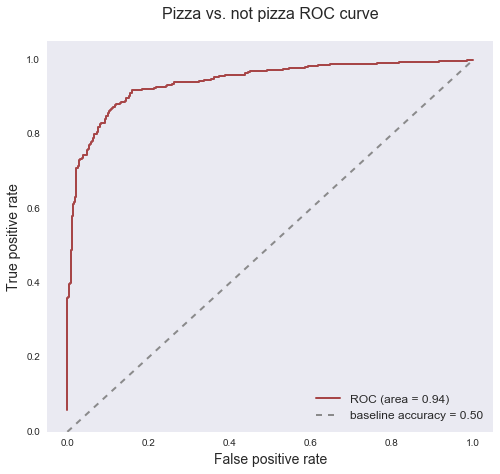

In [28]:
roc(predictions_df['actual_label'], predictions_df['predicted_prob_pizza'])

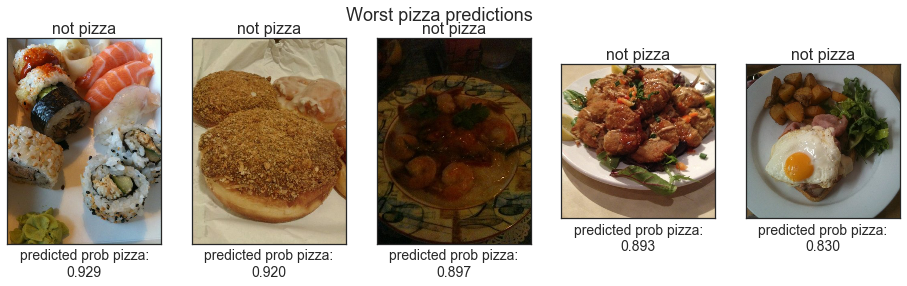

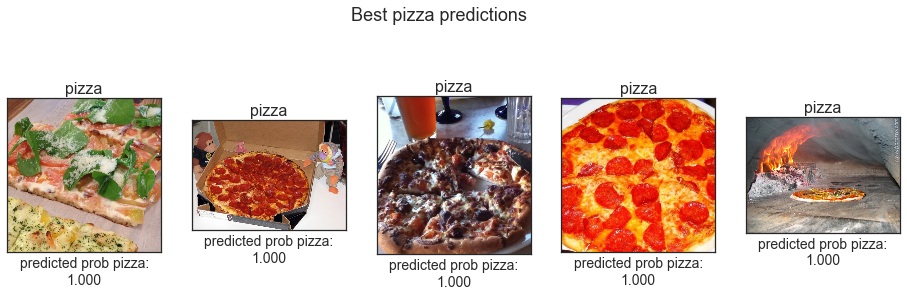

In [29]:
worst = predictions_df[(predictions_df.predicted_label == 1.00) & 
              (predictions_df.actual_label == 0)].sort_values('predicted_prob_pizza', ascending=False)
img_plots(4, worst['filepath'], 'Worst pizza predictions', worst.actual_label, "predicted prob pizza:", 
          worst.predicted_prob_pizza)

best = predictions_df[(predictions_df.predicted_label == 1.00) & 
              (predictions_df.actual_label == 1)].sort_values('predicted_prob_pizza', ascending=False)
img_plots(5, best['filepath'],'Best pizza predictions', best.actual_label, "predicted prob pizza:", best.predicted_prob_pizza)

### Sanity check
Look up prediction on single image.

In [30]:
image = './images/demo/lunch.jpg'
image = image_utils.load_img(image, target_size=(150, 150))
image = image_utils.img_to_array(image)*(1./255.)
image = image.reshape((1,) + image.shape)  

In [31]:
loaded_model.predict_classes(image)

1/1 [==============================] - 0s


array([[1]], dtype=int32)

In [32]:
loaded_model.predict(image)[0][0]

0.55330306

---

## <a name="h">Summary</a>

CNNs are indeed convoluted but also very cool and fascinating to learn about and really the best way to solve this problem. Attempting to build an image classificaton model with SVM, random forest, or K-means would be very challenging (but I actually do want to try them out on this data as well because I'm a maschocist). Overall, my model performs well with 88% accuracy on detecting pizza in an image.  Though, in my research of CNNs, I've learned its actually quite easy to get ~80% accuracy on your model, and really the challenge lies in getting 90% or higher. I could continue to tune the model layers and/or make tweaks to the random transformations to see what improvements I can make. 

I do suspect there is likely a good deal of overfitting because my dataset of images is rather small. Ideally I'd like to train the model on hundreds of thousands of photos. But in practice I don't think this is neccessarily a good learning exercise as pre-trained models exist, such as VGG16, which was trained on ImageNet data (and if I'm understanding correctly that ~14 million photos).

I think an area of improvement is a more comphrensive EDA — perhaps utilizing scikit-image. Additional aspects to explore in the image data are expanding on color (ie variance in cool), texture, shape, etc. I also would like to visualize convolutional layers to get a better sense of what features it is identifying as important in detecting pizza. I'd also like to expand on the results section, for example look at missclassified images and try to discover patterns there.

In terms of next steps — I really like to expand on this and explore building the image-based calorie predictor. I think using a pre-trained model is really the only feasible way to go about this. From there, other issues such as food amount in photos is another challenge to overcome. 
